In [1]:
from __future__ import annotations

import csv
import json
import math
import subprocess
import sys
from datetime import datetime
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Tuple

import importlib
import inspect
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Resolve repo root (works whether cwd is repo root or notebooks/)
CWD = Path.cwd()
if (CWD / "src").exists():
    ROOT = CWD
elif (CWD.parent / "src").exists():
    ROOT = CWD.parent
else:
    ROOT = Path(__file__).resolve().parents[1]

sys.path.insert(0, str(ROOT))
sys.path.insert(0, str(ROOT / "src"))

from geom_np import (  # noqa: E402
    packing_score,
    polygon_bbox,
    polygon_radius,
    prefix_score,
    shift_poses_to_origin,
    transform_polygon,
)
import l2o as l2o_mod  # noqa: E402
from optimizer import run_sa_batch  # noqa: E402
import scripts.train_l2o as train_l2o_mod  # noqa: E402
from tree_data import TREE_POINTS  # noqa: E402

train_l2o_mod = importlib.reload(train_l2o_mod)
l2o_mod = importlib.reload(l2o_mod)
L2OConfig = l2o_mod.L2OConfig
load_params_npz = l2o_mod.load_params_npz
optimize_with_l2o = l2o_mod.optimize_with_l2o


def train_model_safe(**kwargs):
    sig = inspect.signature(train_l2o_mod.train_model)
    allowed = {k: v for k, v in kwargs.items() if k in sig.parameters}
    missing = sorted(set(kwargs) - set(allowed))
    if missing:
        print(f"[warn] train_model ignorou parametros nao suportados: {missing}")
    return train_l2o_mod.train_model(**allowed)

In [2]:
def grid_initial(n: int, spacing: float) -> np.ndarray:
    cols = int(np.ceil(np.sqrt(n)))
    poses = np.zeros((n, 3), dtype=float)
    for i in range(n):
        row = i // cols
        col = i % cols
        poses[i] = (col * spacing, row * spacing, 0.0)
    return poses


def random_initial(n: int, spacing: float, rng: np.random.Generator, rand_scale: float) -> np.ndarray:
    scale = spacing * math.sqrt(max(n, 1)) * rand_scale
    xy = rng.uniform(-scale, scale, size=(n, 2))
    theta = rng.uniform(0.0, 360.0, size=(n, 1))
    return np.concatenate([xy, theta], axis=1)


def make_initial(
    points: np.ndarray,
    n: int,
    spacing: float,
    seed: int,
    init_mode: str,
    rand_scale: float,
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    if init_mode == "grid":
        poses = grid_initial(n, spacing)
    elif init_mode == "random":
        poses = random_initial(n, spacing, rng, rand_scale)
    else:
        poses = grid_initial(n, spacing) if seed % 2 == 0 else random_initial(n, spacing, rng, rand_scale)
    return shift_poses_to_origin(points, poses)

In [3]:
def prefix_packing_score_np(points: np.ndarray, poses: np.ndarray) -> float:
    if poses.shape[0] == 0:
        return 0.0
    min_x = min_y = float("inf")
    max_x = max_y = float("-inf")
    s_values: List[float] = []
    for pose in poses:
        bbox = polygon_bbox(transform_polygon(points, pose))
        min_x = min(min_x, float(bbox[0]))
        min_y = min(min_y, float(bbox[1]))
        max_x = max(max_x, float(bbox[2]))
        max_y = max(max_y, float(bbox[3]))
        width = max_x - min_x
        height = max_y - min_y
        s_values.append(max(width, height))
    return float(prefix_score(s_values))


def plot_packing(poses: np.ndarray, title: str, out_path: Path | None = None) -> None:
    points = np.array(TREE_POINTS, dtype=float)
    plt.figure(figsize=(6, 6))
    for pose in poses:
        poly = transform_polygon(points, pose)
        p = np.vstack([poly, poly[0]])
        plt.plot(p[:, 0], p[:, 1], "g-")
    plt.axis("equal")
    plt.title(title)
    if out_path is not None:
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()


def run_cmd(cmd: List[str]) -> None:
    print("$", " ".join(cmd))
    result = subprocess.run(cmd, cwd=ROOT, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"Command failed with code {result.returncode}")


def l2o_config_from_meta(meta: Dict[str, object], *, reward: str, deterministic: bool) -> L2OConfig:
    def _get_int(key: str, default: int) -> int:
        val = meta.get(key, default)
        return int(val) if hasattr(val, "__int__") else default

    def _get_float(key: str, default: float) -> float:
        val = meta.get(key, default)
        if isinstance(val, (float, np.floating)):
            return float(val)
        if isinstance(val, (int, np.integer)):
            return float(val)
        if isinstance(val, np.ndarray) and val.shape == ():
            return float(val.item())
        return default

    def _get_bool(key: str, default: bool) -> bool:
        val = meta.get(key, default)
        if isinstance(val, (bool, np.bool_)):
            return bool(val)
        if isinstance(val, (int, np.integer)):
            return bool(int(val))
        if isinstance(val, np.ndarray) and val.shape == ():
            return bool(val.item())
        return default

    policy = str(meta.get("policy", "mlp"))
    knn_k = _get_int("knn_k", 4)
    hidden = _get_int("hidden", 32)
    mlp_depth = _get_int("mlp_depth", 1)
    gnn_steps = _get_int("gnn_steps", 1)
    gnn_attention = _get_bool("gnn_attention", False)
    action_scale = _get_float("action_scale", 1.0)
    feature_mode = str(meta.get("feature_mode", "raw"))

    return L2OConfig(
        hidden_size=hidden,
        policy=policy,
        knn_k=knn_k,
        reward=reward,
        mlp_depth=mlp_depth,
        gnn_steps=gnn_steps,
        gnn_attention=gnn_attention,
        feature_mode=feature_mode,
        action_scale=action_scale,
        action_noise=not deterministic,
    )

In [4]:
def evaluate_solver(
    name: str,
    solve_fn: Callable[[int, int], np.ndarray | Tuple[np.ndarray, Dict[str, str]]],
    n_list: Iterable[int],
    seeds: Iterable[int],
    points: np.ndarray,
    split: str,
) -> List[Dict[str, float]]:
    rows: List[Dict[str, float]] = []
    for n in n_list:
        for seed in seeds:
            result = solve_fn(n, seed)
            info: Dict[str, object] = {}
            if isinstance(result, tuple):
                poses, info = result
            else:
                poses = result
            prefix = prefix_packing_score_np(points, poses)
            pack = packing_score(points, poses)
            row = {
                "split": split,
                "model": name,
                "n": int(n),
                "seed": int(seed),
                "prefix_score": float(prefix),
                "packing_score": float(pack),
            }
            if isinstance(info, dict) and "selected" in info:
                row["selected"] = str(info["selected"])
            rows.append(row)
    return rows


def summarize_results(rows: List[Dict[str, float]]) -> List[Dict[str, float]]:
    grouped: Dict[Tuple[str, str, int], List[Dict[str, float]]] = {}
    for row in rows:
        key = (row["split"], row["model"], int(row["n"]))
        grouped.setdefault(key, []).append(row)

    summary: List[Dict[str, float]] = []
    for (split, model, n), items in sorted(grouped.items(), key=lambda x: (x[0][0], x[0][1], x[0][2])):
        prefix_vals = np.array([r["prefix_score"] for r in items], dtype=float)
        pack_vals = np.array([r["packing_score"] for r in items], dtype=float)
        summary.append(
            {
                "split": split,
                "model": model,
                "n": int(n),
                "samples": int(prefix_vals.size),
                "prefix_mean": float(prefix_vals.mean()),
                "prefix_std": float(prefix_vals.std()),
                "packing_mean": float(pack_vals.mean()),
                "packing_std": float(pack_vals.std()),
            }
        )
    return summary


def summarize_overall(rows: List[Dict[str, float]]) -> List[Dict[str, float]]:
    grouped: Dict[Tuple[str, str], List[Dict[str, float]]] = {}
    for row in rows:
        grouped.setdefault((row["split"], row["model"]), []).append(row)

    overall: List[Dict[str, float]] = []
    for (split, model), items in sorted(grouped.items()):
        prefix_vals = np.array([r["prefix_score"] for r in items], dtype=float)
        pack_vals = np.array([r["packing_score"] for r in items], dtype=float)
        overall.append(
            {
                "split": split,
                "model": model,
                "samples": int(prefix_vals.size),
                "prefix_mean": float(prefix_vals.mean()),
                "prefix_std": float(prefix_vals.std()),
                "packing_mean": float(pack_vals.mean()),
                "packing_std": float(pack_vals.std()),
            }
        )
    return overall


def challenge_score_from_results(rows: List[Dict[str, float]], model: str, split: str) -> float:
    grouped: Dict[int, List[float]] = {}
    for row in rows:
        if row.get("model") != model or row.get("split") != split:
            continue
        grouped.setdefault(int(row["n"]), []).append(float(row["packing_score"]))
    total = 0.0
    for n in sorted(grouped):
        mean_s = float(np.mean(grouped[n]))
        total += (mean_s * mean_s) / n
    return total


def write_csv(path: Path, rows: List[Dict[str, float]]) -> None:
    if not rows:
        return
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", newline="") as f:
        fieldnames: List[str] = []
        seen = set()
        for row in rows:
            for key in row.keys():
                if key not in seen:
                    seen.add(key)
                    fieldnames.append(key)
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)


def save_eval_artifacts(
    run_dir: Path,
    rows: List[Dict[str, float]],
    summary: List[Dict[str, float]],
    overall: List[Dict[str, float]],
    meta: Dict[str, object],
) -> None:
    run_dir.mkdir(parents=True, exist_ok=True)
    write_csv(run_dir / "metrics.csv", rows)
    write_csv(run_dir / "per_n.csv", summary)
    write_csv(run_dir / "overall.csv", overall)
    (run_dir / "meta.json").write_text(json.dumps(meta, indent=2))

    lines = [
        "# L2O evaluation summary",
        "",
        "Lower is better. Prefix score matches the leaderboard aggregate.",
        "",
        "## Overall (mean across n and seeds)",
    ]
    for row in overall:
        lines.append(
            f"- [{row['split']}] {row['model']}: prefix={row['prefix_mean']:.4f} +/- {row['prefix_std']:.4f}, "
            f"packing={row['packing_mean']:.4f} +/- {row['packing_std']:.4f}"
        )
    (run_dir / "summary.md").write_text("\n".join(lines))


def plot_eval_curves(summary: List[Dict[str, float]], out_path: Path | None = None) -> None:
    if not summary:
        return
    grouped: Dict[Tuple[str, str], List[Dict[str, float]]] = {}
    for row in summary:
        grouped.setdefault((row["split"], row["model"]), []).append(row)

    plt.figure(figsize=(7, 4))
    for (split, model), items in grouped.items():
        items = sorted(items, key=lambda r: r["n"])
        ns = [r["n"] for r in items]
        means = [r["prefix_mean"] for r in items]
        stds = [r["prefix_std"] for r in items]
        plt.plot(ns, means, marker="o", label=f"{model} ({split})")
        plt.fill_between(ns, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)
    plt.xlabel("n")
    plt.ylabel("prefix score")
    plt.title("Prefix score vs n")
    plt.legend()
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()

In [5]:
# === Configuracoes ===
TRAIN_N_LIST = [8, 10, 12]
VAL_N_LIST = [6, 9, 11]
TRAIN_STEPS = 400
ROLLOUT_STEPS = 50
BATCH = 64
REWARD = "prefix"  # "packing" ou "prefix"
HIDDEN_SIZE = 32
ACTION_SCALE = 0.05
FEATURE_MODE = "raw"  # raw | bbox_norm

BASELINE_MODE = "ema"  # "batch" (baseline por batch) | "ema" (media movel)
BASELINE_DECAY = 0.9

MLP_DEPTH = 2
GNN_STEPS = 2
GNN_ATTENTION = False

TRAIN_EVAL_SEEDS = [0, 1, 2]
VAL_EVAL_SEEDS = [3, 4, 5]
EVAL_STEPS = 50
INIT_MODE = "grid"  # grid | random | mix
RAND_SCALE = 0.3

SA_STEPS = 300
SA_TRANS_SIGMA = 0.2
SA_ROT_SIGMA = 15.0
SA_ROT_PROB = 0.3
SA_OBJECTIVE = REWARD

RUN_BC_PIPELINE = False
BC_POLICY = "gnn"
BC_KNN_K = 4
BC_RUNS_PER_N = 3
BC_STEPS = 200
BC_TRAIN_STEPS = 200
BC_DATASET_PATH = None  # sobrescreva para reutilizar dataset
BC_POLICY_PATH = None  # sobrescreva para reutilizar policy

RUN_META_TRAIN = False
META_INIT_MODEL_PATH = None
META_TRAIN_STEPS = 30
META_ES_POP = 6
META_SA_STEPS = 150

RUN_HEATMAP_TRAIN = False
HEATMAP_MODEL_PATH = None
HEATMAP_TRAIN_STEPS = 30
HEATMAP_ES_POP = 6
HEATMAP_STEPS = 200

RUN_ENSEMBLE = True
ENSEMBLE_SCORE = "prefix"  # criterio de selecao no ensemble
L2O_REFINE_GRID = False
L2O_REFINE_SA = False
REFINE_STEPS = 100

In [6]:
RUN_DIR = ROOT / "runs" / f"l2o_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

points = np.array(TREE_POINTS, dtype=float)
spacing = 2.0 * polygon_radius(points) * 1.2
VIS_N = TRAIN_N_LIST[0]
init = shift_poses_to_origin(points, grid_initial(VIS_N, spacing))

In [7]:
mlp_params, mlp_loss = train_model_safe(
    seed=1,
    n_list=TRAIN_N_LIST,
    batch=BATCH,
    train_steps=TRAIN_STEPS,
    steps=ROLLOUT_STEPS,
    hidden_size=HIDDEN_SIZE,
    policy="mlp",
    reward=REWARD,
    action_scale=ACTION_SCALE,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    baseline_mode=BASELINE_MODE,
    baseline_decay=BASELINE_DECAY,
    feature_mode=FEATURE_MODE,
    verbose_freq=10,
)

[0001] loss=-24022.927734
[0010] loss=-647.816162
[0020] loss=-3480.770264
[0030] loss=6342.567871
[0040] loss=-6177.674805
[0050] loss=-4564.486328
[0060] loss=6686.674805
[0070] loss=-6133.072754
[0080] loss=4673.823242
[0090] loss=-6882.149902
[0100] loss=-8848.871094
[0110] loss=2044.547363
[0120] loss=-9267.439453
[0130] loss=3575.506836
[0140] loss=-8020.340820
[0150] loss=3754.452148
[0160] loss=5697.232422
[0170] loss=5624.851562
[0180] loss=-392.897919
[0190] loss=-5388.269531
[0200] loss=3113.542480
[0210] loss=-7034.673828
[0220] loss=-3913.040039
[0230] loss=2506.852539
[0240] loss=504.955444
[0250] loss=3732.682617
[0260] loss=3864.241699
[0270] loss=5149.677734
[0280] loss=-8565.060547
[0290] loss=-4957.248047
[0300] loss=5128.638672
[0310] loss=-12409.708984
[0320] loss=13507.563477
[0330] loss=12496.681641
[0340] loss=-2745.717285
[0350] loss=6388.879395
[0360] loss=5821.822266
[0370] loss=-16681.113281
[0380] loss=-24442.976562
[0390] loss=-10981.417969
[0400] loss=186

In [8]:
gnn_params, gnn_loss = train_model_safe(
    seed=2,
    n_list=TRAIN_N_LIST,
    batch=BATCH,
    train_steps=TRAIN_STEPS,
    steps=ROLLOUT_STEPS,
    hidden_size=HIDDEN_SIZE,
    policy="gnn",
    reward=REWARD,
    action_scale=ACTION_SCALE,
    knn_k=4,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    baseline_mode=BASELINE_MODE,
    baseline_decay=BASELINE_DECAY,
    feature_mode=FEATURE_MODE,
    verbose_freq=10,
)

[0001] loss=-12100.240234
[0010] loss=-7332.860352
[0020] loss=-6130.185547
[0030] loss=5028.060059
[0040] loss=4388.413574
[0050] loss=-5215.044434
[0060] loss=-4901.842773
[0070] loss=-5900.571289
[0080] loss=7044.321289
[0090] loss=-3784.340820
[0100] loss=11946.551758
[0110] loss=-7218.468750
[0120] loss=-8238.508789
[0130] loss=-5138.334961
[0140] loss=-8604.044922
[0150] loss=-9925.151367
[0160] loss=9747.807617
[0170] loss=-8676.185547
[0180] loss=-4977.771484
[0190] loss=3598.597168
[0200] loss=-5075.153320
[0210] loss=-5581.736328
[0220] loss=-13127.027344
[0230] loss=-10077.771484
[0240] loss=-12620.355469
[0250] loss=-10978.688477
[0260] loss=8121.362793
[0270] loss=-9147.191406
[0280] loss=22376.623047
[0290] loss=-15053.638672
[0300] loss=-8330.230469
[0310] loss=-16665.300781
[0320] loss=-16800.216797
[0330] loss=13530.923828
[0340] loss=23161.257812
[0350] loss=8796.875000
[0360] loss=10245.175781
[0370] loss=2517.804688
[0380] loss=2159.288574
[0390] loss=-4846.344727
[

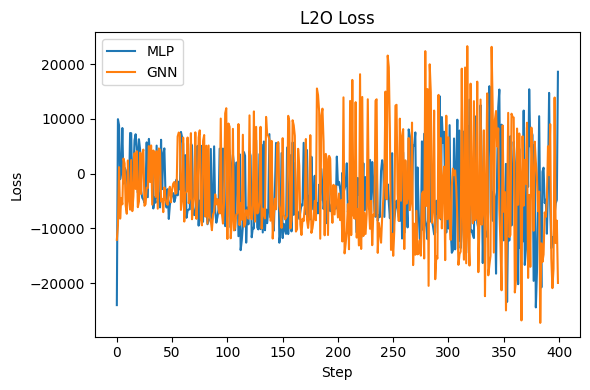

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(mlp_loss, label="MLP")
plt.plot(gnn_loss, label="GNN")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("L2O Loss")
plt.legend()
plt.tight_layout()
plt.savefig(RUN_DIR / "loss_curve.png", dpi=150, bbox_inches="tight")
plt.show()

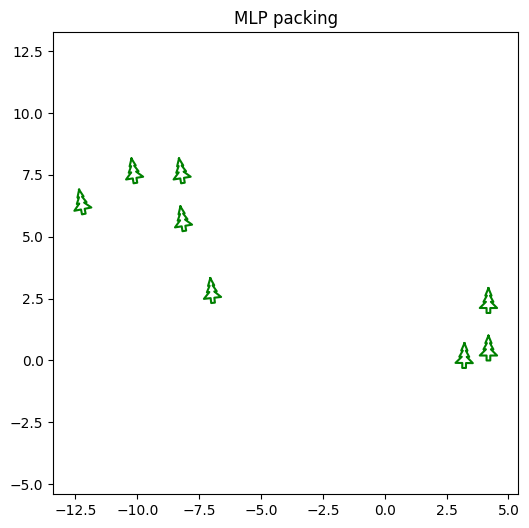

In [10]:
key = jax.random.PRNGKey(0)
config = L2OConfig(
    hidden_size=HIDDEN_SIZE,
    policy="mlp",
    reward=REWARD,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    action_scale=ACTION_SCALE,
    action_noise=False,
)
mlp_poses = optimize_with_l2o(key, mlp_params, jnp.array(init), ROLLOUT_STEPS, config)
plot_packing(np.array(mlp_poses), "MLP packing", RUN_DIR / "mlp_packing.png")

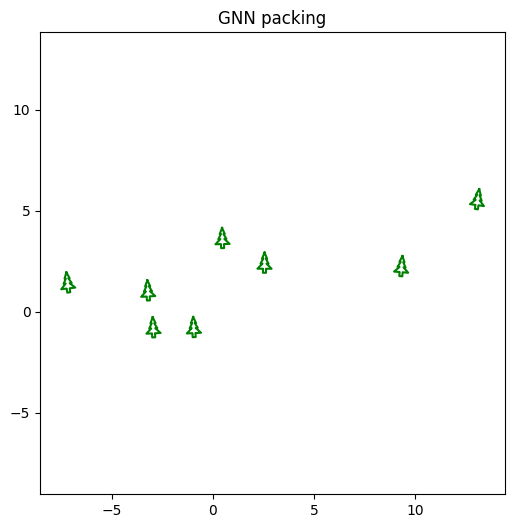

In [11]:
key = jax.random.PRNGKey(1)
config = L2OConfig(
    hidden_size=HIDDEN_SIZE,
    policy="gnn",
    reward=REWARD,
    knn_k=4,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    action_scale=ACTION_SCALE,
    action_noise=False,
)
gnn_poses = optimize_with_l2o(key, gnn_params, jnp.array(init), ROLLOUT_STEPS, config)
plot_packing(np.array(gnn_poses), "GNN packing", RUN_DIR / "gnn_packing.png")

In [12]:
bc_policy_path: Path | None = Path(BC_POLICY_PATH) if BC_POLICY_PATH else None

In [13]:
if RUN_BC_PIPELINE:
    bc_dataset = Path(BC_DATASET_PATH) if BC_DATASET_PATH else RUN_DIR / "bc_dataset.npz"
    bc_policy_path = Path(BC_POLICY_PATH) if BC_POLICY_PATH else RUN_DIR / "bc_policy.npz"
    run_cmd(
        [
            sys.executable,
            str(ROOT / "scripts" / "collect_sa_dataset.py"),
            "--n-list",
            ",".join(str(n) for n in TRAIN_N_LIST),
            "--runs-per-n",
            str(BC_RUNS_PER_N),
            "--steps",
            str(BC_STEPS),
            "--init",
            INIT_MODE,
            "--out",
            str(bc_dataset),
        ]
    )
    train_cmd = [
        sys.executable,
        str(ROOT / "scripts" / "train_l2o_bc.py"),
        "--dataset",
        str(bc_dataset),
        "--policy",
        BC_POLICY,
        "--knn-k",
        str(BC_KNN_K),
        "--train-steps",
        str(BC_TRAIN_STEPS),
        "--reward",
        REWARD,
        "--hidden",
        str(HIDDEN_SIZE),
        "--mlp-depth",
        str(MLP_DEPTH),
        "--gnn-steps",
        str(GNN_STEPS),
        "--out",
        str(bc_policy_path),
    ]
    if GNN_ATTENTION:
        train_cmd.append("--gnn-attention")
    run_cmd(train_cmd)

In [14]:
meta_init_path: Path | None = Path(META_INIT_MODEL_PATH) if META_INIT_MODEL_PATH else None
if RUN_META_TRAIN:
    meta_init_path = Path(META_INIT_MODEL_PATH) if META_INIT_MODEL_PATH else RUN_DIR / "meta_init.npz"
    run_cmd(
        [
            sys.executable,
            str(ROOT / "scripts" / "train_meta_init.py"),
            "--n-list",
            ",".join(str(n) for n in TRAIN_N_LIST),
            "--train-steps",
            str(META_TRAIN_STEPS),
            "--es-pop",
            str(META_ES_POP),
            "--sa-steps",
            str(META_SA_STEPS),
            "--out",
            str(meta_init_path),
        ]
    )

In [15]:
heatmap_path: Path | None = Path(HEATMAP_MODEL_PATH) if HEATMAP_MODEL_PATH else None
if RUN_HEATMAP_TRAIN:
    heatmap_path = Path(HEATMAP_MODEL_PATH) if HEATMAP_MODEL_PATH else RUN_DIR / "heatmap_meta.npz"
    run_cmd(
        [
            sys.executable,
            str(ROOT / "scripts" / "train_heatmap_meta.py"),
            "--n-list",
            ",".join(str(n) for n in TRAIN_N_LIST),
            "--train-steps",
            str(HEATMAP_TRAIN_STEPS),
            "--es-pop",
            str(HEATMAP_ES_POP),
            "--heatmap-steps",
            str(HEATMAP_STEPS),
            "--policy",
            "gnn",
            "--knn-k",
            str(BC_KNN_K),
            "--out",
            str(heatmap_path),
        ]
    )

In [16]:
if set(TRAIN_N_LIST) & set(VAL_N_LIST):
    raise ValueError("TRAIN_N_LIST and VAL_N_LIST must be disjoint to avoid leakage.")

In [17]:
bc_params = None
bc_config = None
if bc_policy_path is not None and bc_policy_path.exists():
    bc_params, bc_meta = load_params_npz(bc_policy_path)
    bc_config = l2o_config_from_meta(bc_meta, reward=REWARD, deterministic=True)

In [18]:
initial_cache: Dict[Tuple[int, int], np.ndarray] = {}


def get_initial(n: int, seed: int) -> np.ndarray:
    key = (n, seed)
    if key not in initial_cache:
        initial_cache[key] = make_initial(points, n, spacing, seed, INIT_MODE, RAND_SCALE)
    return initial_cache[key]


def solve_grid(n: int, seed: int) -> np.ndarray:
    return get_initial(n, seed)


def solve_sa(n: int, seed: int) -> np.ndarray:
    init_pose = get_initial(n, seed)
    init_batch = jnp.array(init_pose)[None, :, :]
    key = jax.random.PRNGKey(seed)
    best_poses, _ = run_sa_batch(
        key,
        SA_STEPS,
        n,
        init_batch,
        trans_sigma=SA_TRANS_SIGMA,
        rot_sigma=SA_ROT_SIGMA,
        rot_prob=SA_ROT_PROB,
        objective=SA_OBJECTIVE,
    )
    return np.array(best_poses[0])


def solve_l2o(params, cfg: L2OConfig) -> Callable[[int, int], np.ndarray]:
    def _solve(n: int, seed: int) -> np.ndarray:
        init_pose = get_initial(n, seed)
        key = jax.random.PRNGKey(seed)
        poses = optimize_with_l2o(key, params, jnp.array(init_pose), EVAL_STEPS, cfg)
        return np.array(poses)

    return _solve


def solve_l2o_refine(base_solver: Callable[[int, int], np.ndarray], params, cfg: L2OConfig) -> Callable[[int, int], np.ndarray]:
    def _solve(n: int, seed: int) -> np.ndarray:
        base_pose = base_solver(n, seed)
        key = jax.random.PRNGKey(seed)
        poses = optimize_with_l2o(key, params, jnp.array(base_pose), REFINE_STEPS, cfg)
        return np.array(poses)

    return _solve


def solve_meta_init_sa(n: int, seed: int) -> np.ndarray:
    if meta_init_path is None or not meta_init_path.exists():
        return solve_sa(n, seed)
    try:
        from meta_init import MetaInitConfig, apply_meta_init, load_meta_params  # noqa: E402
    except Exception:
        return solve_sa(n, seed)
    params, meta = load_meta_params(meta_init_path)
    config = MetaInitConfig(
        hidden_size=int(meta.get("hidden", 32)) if hasattr(meta.get("hidden", 32), "__int__") else 32,
        delta_xy=float(meta.get("delta_xy", 0.2)),
        delta_theta=float(meta.get("delta_theta", 10.0)),
    )
    init_pose = get_initial(n, seed)
    init_pose = np.array(apply_meta_init(params, jnp.array(init_pose), config))
    init_batch = jnp.array(init_pose)[None, :, :]
    key = jax.random.PRNGKey(seed)
    best_poses, _ = run_sa_batch(
        key,
        SA_STEPS,
        n,
        init_batch,
        trans_sigma=SA_TRANS_SIGMA,
        rot_sigma=SA_ROT_SIGMA,
        rot_prob=SA_ROT_PROB,
        objective=SA_OBJECTIVE,
    )
    return np.array(best_poses[0])


def solve_heatmap(n: int, seed: int) -> np.ndarray:
    if heatmap_path is None or not heatmap_path.exists():
        return solve_grid(n, seed)
    try:
        from heatmap_meta import HeatmapConfig, heatmap_search, load_params  # noqa: E402
    except Exception:
        return solve_grid(n, seed)
    params, meta = load_params(heatmap_path)
    config = HeatmapConfig(
        hidden_size=int(meta.get("hidden", 32)) if hasattr(meta.get("hidden", 32), "__int__") else 32,
        policy=str(meta.get("policy", "gnn")),
        knn_k=int(meta.get("knn_k", 4)) if hasattr(meta.get("knn_k", 4), "__int__") else 4,
        heatmap_lr=float(meta.get("heatmap_lr", 0.1)),
        trans_sigma=float(meta.get("trans_sigma", 0.2)),
        rot_sigma=float(meta.get("rot_sigma", 10.0)),
    )
    base = get_initial(n, seed)
    rng = np.random.default_rng(seed)
    poses, _ = heatmap_search(params, base, config, HEATMAP_STEPS, rng)
    return np.array(poses)


def solve_ensemble(candidates: Dict[str, Callable[[int, int], np.ndarray]]) -> Callable[[int, int], Tuple[np.ndarray, Dict[str, str]]]:
    def _solve(n: int, seed: int) -> Tuple[np.ndarray, Dict[str, str]]:
        best_score = float("inf")
        best_pose: np.ndarray | None = None
        best_name = "none"
        for name, fn in candidates.items():
            poses = fn(n, seed)
            if ENSEMBLE_SCORE == "packing":
                score = packing_score(points, poses)
            else:
                score = prefix_packing_score_np(points, poses)
            if score < best_score:
                best_score = float(score)
                best_pose = poses
                best_name = name
        if best_pose is None:
            best_pose = candidates[next(iter(candidates))](n, seed)
        return best_pose, {"selected": best_name}

    return _solve

In [19]:
results: List[Dict[str, float]] = []
l2o_mlp_cfg = L2OConfig(
    hidden_size=HIDDEN_SIZE,
    policy="mlp",
    reward=REWARD,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    action_scale=ACTION_SCALE,
    feature_mode=FEATURE_MODE,
    action_noise=False,
)
l2o_gnn_cfg = L2OConfig(
    hidden_size=HIDDEN_SIZE,
    policy="gnn",
    reward=REWARD,
    knn_k=4,
    mlp_depth=MLP_DEPTH,
    gnn_steps=GNN_STEPS,
    gnn_attention=GNN_ATTENTION,
    action_scale=ACTION_SCALE,
    feature_mode=FEATURE_MODE,
    action_noise=False,
)

In [20]:
results += evaluate_solver("grid", solve_grid, TRAIN_N_LIST, TRAIN_EVAL_SEEDS, points, split="train")
results += evaluate_solver("grid", solve_grid, VAL_N_LIST, VAL_EVAL_SEEDS, points, split="val")
results += evaluate_solver("sa", solve_sa, TRAIN_N_LIST, TRAIN_EVAL_SEEDS, points, split="train")
results += evaluate_solver("sa", solve_sa, VAL_N_LIST, VAL_EVAL_SEEDS, points, split="val")

In [21]:
results += evaluate_solver(
    "l2o_mlp",
    solve_l2o(mlp_params, l2o_mlp_cfg),
    TRAIN_N_LIST,
    TRAIN_EVAL_SEEDS,
    points,
    split="train",
)
results += evaluate_solver(
    "l2o_gnn",
    solve_l2o(gnn_params, l2o_gnn_cfg),
    TRAIN_N_LIST,
    TRAIN_EVAL_SEEDS,
    points,
    split="train",
)
results += evaluate_solver(
    "l2o_mlp",
    solve_l2o(mlp_params, l2o_mlp_cfg),
    VAL_N_LIST,
    VAL_EVAL_SEEDS,
    points,
    split="val",
)
results += evaluate_solver(
    "l2o_gnn",
    solve_l2o(gnn_params, l2o_gnn_cfg),
    VAL_N_LIST,
    VAL_EVAL_SEEDS,
    points,
    split="val",
)

In [22]:
if bc_params is not None and bc_config is not None:
    results += evaluate_solver(
        "l2o_bc",
        solve_l2o(bc_params, bc_config),
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "l2o_bc",
        solve_l2o(bc_params, bc_config),
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

if meta_init_path is not None and meta_init_path.exists():
    results += evaluate_solver(
        "sa_meta_init",
        solve_meta_init_sa,
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "sa_meta_init",
        solve_meta_init_sa,
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

if heatmap_path is not None and heatmap_path.exists():
    results += evaluate_solver(
        "heatmap",
        solve_heatmap,
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "heatmap",
        solve_heatmap,
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

if L2O_REFINE_GRID:
    results += evaluate_solver(
        "l2o_refine_grid",
        solve_l2o_refine(solve_grid, mlp_params, l2o_mlp_cfg),
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "l2o_refine_grid",
        solve_l2o_refine(solve_grid, mlp_params, l2o_mlp_cfg),
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

if L2O_REFINE_SA:
    results += evaluate_solver(
        "l2o_refine_sa",
        solve_l2o_refine(solve_sa, gnn_params, l2o_gnn_cfg),
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "l2o_refine_sa",
        solve_l2o_refine(solve_sa, gnn_params, l2o_gnn_cfg),
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

In [23]:
if RUN_ENSEMBLE:
    ensemble_candidates = {
        "grid": solve_grid,
        "sa": solve_sa,
        "l2o_mlp": solve_l2o(mlp_params, l2o_mlp_cfg),
        "l2o_gnn": solve_l2o(gnn_params, l2o_gnn_cfg),
    }
    if bc_params is not None and bc_config is not None:
        ensemble_candidates["l2o_bc"] = solve_l2o(bc_params, bc_config)
    if meta_init_path is not None and meta_init_path.exists():
        ensemble_candidates["sa_meta_init"] = solve_meta_init_sa
    if heatmap_path is not None and heatmap_path.exists():
        ensemble_candidates["heatmap"] = solve_heatmap
    results += evaluate_solver(
        "ensemble",
        solve_ensemble(ensemble_candidates),
        TRAIN_N_LIST,
        TRAIN_EVAL_SEEDS,
        points,
        split="train",
    )
    results += evaluate_solver(
        "ensemble",
        solve_ensemble(ensemble_candidates),
        VAL_N_LIST,
        VAL_EVAL_SEEDS,
        points,
        split="val",
    )

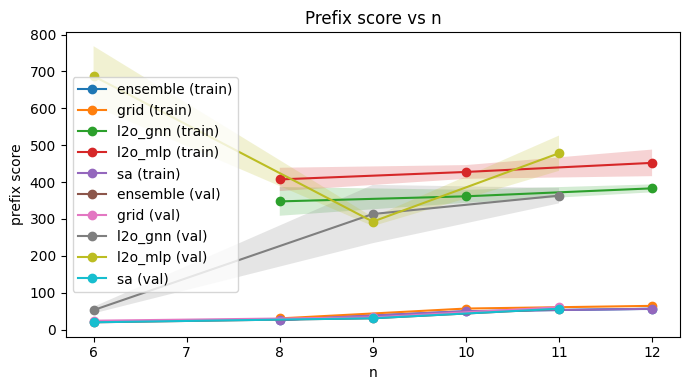

In [24]:
per_n = summarize_results(results)
overall = summarize_overall(results)

meta = {
    "reward": REWARD,
    "train_n_list": TRAIN_N_LIST,
    "val_n_list": VAL_N_LIST,
    "train_eval_seeds": TRAIN_EVAL_SEEDS,
    "val_eval_seeds": VAL_EVAL_SEEDS,
    "train_steps": TRAIN_STEPS,
    "rollout_steps": ROLLOUT_STEPS,
    "batch": BATCH,
    "eval_steps": EVAL_STEPS,
    "hidden_size": HIDDEN_SIZE,
    "mlp_depth": MLP_DEPTH,
    "gnn_steps": GNN_STEPS,
    "gnn_attention": GNN_ATTENTION,
    "action_scale": ACTION_SCALE,
    "feature_mode": FEATURE_MODE,
    "baseline_mode": BASELINE_MODE,
    "baseline_decay": BASELINE_DECAY,
    "init_mode": INIT_MODE,
    "rand_scale": RAND_SCALE,
    "sa_steps": SA_STEPS,
    "sa_trans_sigma": SA_TRANS_SIGMA,
    "sa_rot_sigma": SA_ROT_SIGMA,
    "sa_rot_prob": SA_ROT_PROB,
    "sa_objective": SA_OBJECTIVE,
    "run_bc_pipeline": RUN_BC_PIPELINE,
    "bc_policy": BC_POLICY,
    "bc_runs_per_n": BC_RUNS_PER_N,
    "bc_steps": BC_STEPS,
    "bc_train_steps": BC_TRAIN_STEPS,
    "bc_policy_path": str(bc_policy_path) if bc_policy_path else None,
    "run_meta_train": RUN_META_TRAIN,
    "meta_init_path": str(meta_init_path) if meta_init_path else None,
    "run_heatmap_train": RUN_HEATMAP_TRAIN,
    "heatmap_path": str(heatmap_path) if heatmap_path else None,
    "run_ensemble": RUN_ENSEMBLE,
    "ensemble_score": ENSEMBLE_SCORE,
    "l2o_refine_grid": L2O_REFINE_GRID,
    "l2o_refine_sa": L2O_REFINE_SA,
    "refine_steps": REFINE_STEPS,
}

save_eval_artifacts(RUN_DIR, results, per_n, overall, meta)
plot_eval_curves(per_n, RUN_DIR / "eval_curve.png")

In [25]:
gnn_train_score = challenge_score_from_results(results, "l2o_gnn", "train")
gnn_val_score = challenge_score_from_results(results, "l2o_gnn", "val")
(RUN_DIR / "gnn_score.txt").write_text(
    f"gnn_train_score={gnn_train_score:.6f}\n"
    f"gnn_val_score={gnn_val_score:.6f}\n"
)

print("GNN score (challenge-style):")
print(f"  train={gnn_train_score:.6f}")
print(f"  val={gnn_val_score:.6f}")
print("Eval artifacts saved to", RUN_DIR)

GNN score (challenge-style):
  train=99.403889
  val=72.110648
Eval artifacts saved to /home/marcusvinicius/Repositorios/Kaggle/Santa 2025 - Christmas Tree Packing Challenge/runs/l2o_eval_20251231_180418


In [26]:
SUBMISSION_NMAX = 200
SUBMISSION_SEED = 1
SUBMISSION_MODEL = "ensemble"  # grid | sa | l2o_mlp | l2o_gnn | ensemble
SUBMISSION_OUT = RUN_DIR / "submission.csv"


def format_submission_value(value: float) -> str:
    return f"s{value:.17f}"


def _submission_solver(name: str) -> Callable[[int, int], np.ndarray | Tuple[np.ndarray, Dict[str, str]]]:
    name = name.lower()
    if name == "grid":
        return solve_grid
    if name == "sa":
        return solve_sa
    if name == "l2o_mlp":
        return solve_l2o(mlp_params, l2o_mlp_cfg)
    if name == "l2o_gnn":
        return solve_l2o(gnn_params, l2o_gnn_cfg)
    if name == "ensemble":
        candidates = {
            "grid": solve_grid,
            "sa": solve_sa,
            "l2o_mlp": solve_l2o(mlp_params, l2o_mlp_cfg),
            "l2o_gnn": solve_l2o(gnn_params, l2o_gnn_cfg),
        }
        if bc_params is not None and bc_config is not None:
            candidates["l2o_bc"] = solve_l2o(bc_params, bc_config)
        if meta_init_path is not None and meta_init_path.exists():
            candidates["sa_meta_init"] = solve_meta_init_sa
        if heatmap_path is not None and heatmap_path.exists():
            candidates["heatmap"] = solve_heatmap
        return solve_ensemble(candidates)
    raise ValueError(f"Unknown SUBMISSION_MODEL='{name}'")


def write_submission_csv(
    out_path: Path,
    solver: Callable[[int, int], np.ndarray | Tuple[np.ndarray, Dict[str, str]]],
    *,
    nmax: int,
    seed: int,
) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["id", "x", "y", "deg"])
        for n in range(1, nmax + 1):
            result = solver(n, seed + n)
            poses = result[0] if isinstance(result, tuple) else result
            poses = np.array(poses, dtype=float)
            if poses.shape[0] != n:
                raise ValueError(f"Submission puzzle {n} expected {n} trees, got {poses.shape[0]}")
            poses[:, 2] = np.mod(poses[:, 2], 360.0)
            for i, (x, y, deg) in enumerate(poses):
                writer.writerow(
                    [
                        f"{n:03d}_{i}",
                        format_submission_value(float(x)),
                        format_submission_value(float(y)),
                        format_submission_value(float(deg)),
                    ]
                )


submission_solver = _submission_solver(SUBMISSION_MODEL)
write_submission_csv(SUBMISSION_OUT, submission_solver, nmax=SUBMISSION_NMAX, seed=SUBMISSION_SEED)
print("Submission saved to", SUBMISSION_OUT)


Submission saved to /home/marcusvinicius/Repositorios/Kaggle/Santa 2025 - Christmas Tree Packing Challenge/runs/l2o_eval_20251231_180418/submission.csv
